In [1]:
# Data
import numpy as np

# if __name__ == '__main__':
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}
    
    X = [char_to_idx[x] for x in txt]
    X = np.array(X)
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
# Model
import impl.layer as l

class RNN:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(H / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))
    
    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        #         u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX

    def forward(self, X, h, m, train):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()
        X_one_hot = X.copy()
    
        X = (X_one_hot @ Wxh) + (hprev @ Whh) + bh
        h, h_cache = l.tanh_forward(X)
        
        y, y_cache = l.fc_forward(h, Why, by)

        # Dropout for training
        if train:
            y, y_do_cache = self.dropout_forward(X=y, p_dropout=self.p_dropout)
            cache = (X_one_hot, Wxh, hprev, Whh, h_cache, y_cache, y_do_cache)
        else:
            cache = (X_one_hot, Wxh, hprev, Whh, h_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        #         if train: 
        # Backward is performed for learning/training and not testing or validation.
        X_one_hot, Wxh, hprev, Whh, h_cache, y_cache, y_do_cache = cache
        dy = self.dropout_backward(dout=dy, cache=y_do_cache)

        dh_next = dh.copy()
        
        # Hidden to output gradient
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        # tanh
        dX_one_hot = l.tanh_backward(dh, h_cache)

        # Hidden gradient
        dbh = dX_one_hot * 1.0
        dWhh = hprev.T @ dX_one_hot
        dWxh = X_one_hot.T @ dX_one_hot
        
        dX = dX_one_hot @ Wxh.T
        dh = dX_one_hot @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy() # the output for the previous layer is the input for the next layer
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t]) # train=True
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy() # The input for the next layer is the output for the previous layer
            dXs.append(dX)
            
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    eps = 1e-8
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):

        # No full batch or files
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
    
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100)
            print(sample)
            
    return nn

Iter-10 loss: 124.0747
e(cgBbHjSe,lm本KbC9MU2WlcmnwNti;cx:%日RiW"e–iw)e本ntcf2EeaW1iLa本kDEiubMMNtd5js7;oL6FtD本4s)hN7duasryS–elt
Iter-20 loss: 106.2611
e日NA3"yTd7sy8rra.NeUout 9cw nwes wfst–PMftrihPhrtrafahota  dO neelews–iheai1 ttafIkb Dtw   ieh a" aeT
Iter-30 loss: 108.0775
ePthmMr BhntbR  Ugk ara i uh2 sbeAuoolehs airttDuncsnt  akprti- nd brdet yspgoodicE8a stf rprclSn 2sa
Iter-40 loss: 106.0726
eE1vOill i-l 8iis iel oiyus  iide 'fa Cedto n eliWelre-thn pidcMi sWnwri8lCh dw g Cil oi  kh 6lstkoef
Iter-50 loss: 104.1235
eoThs t ttaahs mtagpbse smnom aa var rtoyr dp a-tip sfhhise tlaaldo nisttadd z lic'a.eii  itlS  i Sh 
Iter-60 loss: 104.0994
e.(vra xuusrJ nttese iyr tn vperhwrdiracredaia1 plgnfoandvi  paiaterearooewemdandroe  ri ners eaa,an 
Iter-70 loss: 99.3134
eBs1ni1uhts1 rerfhn erf Ir7f etnt tJchwgl5 ia  odotcdnierh inmeohiehntta6 he ilhta na ieor,ag's cpg h
Iter-80 loss: 100.9485
e"RDtf 's gpl
dBioyxte.aaotheortnteai diat.e ia  oe i日  iemT sot  ofynd etr  ar1Jvesaea "e  )cvaftsut
I

Iter-670 loss: 65.2916
eelhiventhe oi9gkof wer se nioyts. eabl JheaSestcwofit condd, the 1agte ralegeat in Rasincewor sicnie
Iter-680 loss: 57.5149
e'n fasd aane congert wipan eatae Winecinrm taro wan ala aus fboas ,the, Tatcalee. thr Rnsfeirtr ws b
Iter-690 loss: 64.6545
ecGar  file lople matr es aatdosinas an 18etn fhr .yprt warad tard tf arrtey aso oid ,ond ,hys  arcok
Iter-700 loss: 64.6340
e, aod Eurso%f rh terrir tan and ioNin Oyg
n.Mpartiatc nsich' ro4n, tht 1r. phr Tsi5he RoC,lae  acato
Iter-710 loss: 62.6590
eb2Ty Javooes aiutd r94tran coI pob8 bi an fedand it the Rlfmiehtinb eree oNit ,oft itegd opothi ithn
Iter-720 loss: 58.3846
enIree. ropJongd1so angisoal theyRh lomd th isN ily lomiss ano1desLesine cerld rBthi fNLsxin1 gad fnP
Iter-730 loss: 59.9207
e the Serrhxdiby anenIeilgcred 3eaead i1un avgstumise ifgr. guveuch 6 pupgrkti teinyd colenciand O"va
Iter-740 loss: 59.3005
e9oce ooktdnl ohise pan faperuth  Eevelcho Uert- iolrd Ry )i5. andena9e at eapan ra, toredf cultstmin


Iter-1330 loss: 42.2477
ew,ius JapeO, eika  of liven ald Ghe berthe the cofli's Icumore lut3h.5J-panc mrrex and Japan insea a
Iter-1340 loss: 47.2673
eJ phn ef ahd R IngeHllohok. Jaiancipanusm agdtid in oito, mhe fopetrrasticeOtobowil Aored War of Eap
Iter-1350 loss: 45.6910
e War of Napk本ats ingloea. thw seuAnt5 ine an 1yr h othithe 18jc wrmpupceataly erlloesturgusofiy eala
Iter-1360 loss: 41.8005
eNp8rusth ioald TotcouAst and chnclfbusy in o-ingond ri, th. s. fira anoT. an Se tho f oey.Rr, istar 
Iter-1370 loss: 44.9484
e6. and coand argise ar onne9ebt bf Japioes xi tienter uratrgs fhes tand is 18Skidsy pandeoche Wigg a
Iter-1380 loss: 51.6137
e:"bopnd Ie mpegt8ry Ashac an CR whe tares fof thin liag Kt the worrored Jipateitis torldes ap.nil ci
Iter-1390 loss: 47.3942
e Nof on khd urpis inUNso"oke –her of onteela wit bin Ciglerooat. baly pived eoery If Gho ffrstd tse 
Iter-1400 loss: 43.1758
e. The s2antod ahd the the hio, the Garit, oapet on ioly, As toperlxeanginstarnisgelWoy sived 

Iter-1990 loss: 37.0352
eveapyins diuly'cud Jupes thia tise Gn the bEmbh mouly. ro fn itere, anst-. omllreat the. Theld Sin r
Iter-2000 loss: 34.3061
eg ioty chan, wor he free in Naso"ok.  9ina. pat t"s h, Emituton Natt opel wis  ard Nhesoupery ssclfe
Iter-2010 loss: 32.8434
e6 worla, tho veumbed Gig thopeguman so 9hic afrt eocan, Titshis tha Ersturcen.appen, wareI il Gapiyg
Iter-2020 loss: 32.3857
e Soplobe ts ofOlyPlaxe thon Paland le 19ve 1mmoweol mios rofroen mpreomarldan Sty- aslaceanet2 ss of
Iter-2030 loss: 33.2760
e Jaran' Iyveseriond niry if uurereanctesfldsind in es lurar glliiert cond rudss folopand if the into
Iter-2040 loss: 40.6070
e Solrod desta calae tures inliosouriut in 1861847Japan'se and an iwhe Japand maresicin tur on ichan 
Iter-2050 loss: 35.6714
erlasistr is the tomines imed, wosulup-on A86ryn isrtucopol cuneanin, baccof minlag ft. carycertae an
Iter-2060 loss: 42.1363
e the ocxmalgooftmeh sh fh sr urto-. Wo lory. "h. 6fl9roit lhceceanaro te Sie tf otPlagesfhG B

Iter-2650 loss: 28.6133
e worrd in msepoof ixur Inieseano th fEusbce eoflien itg eceperurb io sn iss ko0本 ", pares war dinay 
Iter-2660 loss: 31.3776
erJ-panky paree i the Riston "ofe er regeamion. n8ry, whi obal Donnthe angoy tyrestat on t9elilila, K
Iter-2670 loss: 25.8980
e: ropsr fiola, inter andend is the nwmrtaenas the almeoke oniagin turevty ingtist isto yaly sith- an
Iter-2680 loss: 27.9598
e, whr h atginly ppacanes wirnd cures s sod fven od Ing bor d, hh comDd itig Win ortd f"Runce-taml1bn
Iter-2690 loss: 35.9091
ed che Word sn riea, The constury. Tis c:ugny rive Japan th whes sur trokad the Gfury. Aseandestor wa
Iter-2700 loss: 27.9956
e Sof ist  smargins a aed wistd wevelichin thity-lereot wof Hropantile woploun he Nthe Nlate  irthe f
Iter-2710 loss: 35.8363
e Sirgns cofboundiand D anrei olme in rur UChirin wom 1stcynpext roulhopan, wakeb, ghe fds af The Pow
Iter-2720 loss: 46.2626
e Japan'in andpcroutrd s8vy fO, pan tarins andeIon bed bofedin thevelWog the Esperess rrcorxUs

Iter-3310 loss: 23.7343
ed toWik e peragnter ar Inf 941 2Co Napanese faed of mive fe ingages iou,,naish icd rede tolyhir G, J
Iter-3320 loss: 20.1842
eoconancin ty ofb3a bnas  Chono-Senth sary to on lheso  Japenolasith isl be the Uans ienthe apred. Ja
Iter-3330 loss: 20.0115
erea inrt in the Sont-taluckeetbins of dskeoA, topen per urt marctincanced tor 1rha. Tse poplothe the
Iter-3340 loss: 20.8902
e an, ofobof llvDees orghse cofbRuroy- ofe wppife. Th 18ry fiat ind ligetat rta lempea tooetan thesta
Iter-3350 loss: 30.6078
e Ghe a. coultho ebrlanicyCof isst ing latisg indm ealicwes went thece rmrbw1d Japan wy cunthigats an
Iter-3360 loss: 20.7923
e war ceand d ingelecon mie bopr of Japanes sr freaches porukcy forouthin  Hed Aikin Wnk 9es lethe Gp
Iter-3370 loss: 36.4566
e por troked Gh lac os torla ly, "a and iint ros anod en of ontanica enos. casiche Empeanith Japan we
Iter-3380 loss: 41.7762
e-Japan'h lounsre Wa lyd epeathe an East miit on the Japan wase thd Etrexmatane livgisl coktou

Iter-3970 loss: 17.7218
ec ofrla hedes lom rary Japopasctanece latirch wourons acdy-3algetce seveithoJapanDe In the anira S. 
Iter-3980 loss: 27.2208
es th ivliteog so, Ithe Gasin a s rhe Wirly.17ts wonis comy and oflean the wwrma and ok5 ffithe durbi
Iter-3990 loss: 20.9735
e tore to the onuryy an had inte Nathon, pory. Stitn oIelegf mhig thia ligho Worc, carexth oomy-lared
Iter-4000 loss: 19.5187
eg Wor sto maila pon wex tonita anafitatin lare ch 1hes anhig the ioled whicn melithe Wan on 1233s20e
Iter-4010 loss: 17.5131
e the the ioste warc an ricyn A9oos lumyed iagein lofDe"t inel  doothise coflarhe co-kowh be lothrser
Iter-4020 loss: 26.6562
ecof-tsd arlig 19ted wnsca deso or fo th l9tmen ioped in 1orolaty ur asuand warc and , th Norpan,end 
Iter-4030 loss: 25.8613
es. Japa urbo-saJapankid themcoulliy  hig of20 rpalot-d fe ts aited simpar th mopmon ro codtal inte e
Iter-4040 loss: 20.4567
e. The chuped in tudy "ni shankey fiC thesikgt malactand Wand ianiyn an Gtheakicenjreatly sole

Iter-4630 loss: 21.5109
e the ialme maticinalle 17th wontes toreswar ofe Eaig the G7, whes, the RestolUdan iol arche tom arg 
Iter-4640 loss: 19.0697
es ar is an SikeoInd Sea es 1947 cJapan cecwuErse Japen's rand f ion red "sr the al hes thithio lim P
Iter-4650 loss: 22.2718
ery-fecovlathes Emed WurcThiky. worexth-kar ootiol of 1935 worldy, ware wor dest. isl cont ri Es, wir
Iter-4660 loss: 17.9985
ed of ss the angsth me the fmiet anso, hiry orl in of sivin 18,1wwis iid se ishn red aroe ti. os ufok
Iter-4670 loss: 19.9286
ed orenthiiges larod, thital miot wurleaniv. ctret loomerenwas e tht iraty Silom he eoullit. Th unanc
Iter-4680 loss: 22.7855
e toresta  fofeakco ferlat en operthe worl if5 Sudbof UpWand If ixpan, Ko mhirs lation ais Che Empane
Iter-4690 loss: 18.7493
ed bor tor sed lore elomiory NJapin Assanouno nomdeatand Ote tiro, mat onurlatity cobally 1rthe chith
Iter-4700 loss: 21.9671
e wiry lag of pano.we tupbellcofes ig rid oand Wercoulan, wh. Jaian ethan end Rutory. Japang C

Iter-5290 loss: 17.9729
e Sord-Japandsy waplits chasea 12y 2Fisstan ery ired, whe tevelyppetctutes andSenwar e feret in the w
Iter-5300 loss: 16.9146
e and the Oliond vimin iw the Fwpelasto of6lucconomxmbyond ced stred hi ht Seati I argestl ofetenollp
Iter-5310 loss: 21.2070
e ppretr des popod werid sinithe an the wor he chettvecdard I mevtomgealared he torherousd hn miplory
Iter-5320 loss: 15.2936
e Soulnd paty urbo, the Inumbet Piam. fh.
. worl tithe a liagrec aseromrost fEese rasis.
. fn lopase 
Iter-5330 loss: 15.9527
ed the torlaca is as the Empenour im the asleades Tukand cerumily ingthe asr afecoufesoponsingese ofb
Iter-5340 loss: 14.8711
e parcer mudcotgest of the ipinownku, panaldenthe af the warly. Aseanced pagseouled The fLutt marlotu
Iter-5350 loss: 17.2966
ed the thits weris red Jape wh cokres ind cf lore min the woflery wati ang DevArman a. Th 12 rs lito 
Iter-5360 loss: 25.8763
ef intereandun"we sta isint murlali's cand irste wast the wepbi ed ol of 19tind gagity. Nmikh 

Iter-5950 loss: 22.8153
e parry-tovin the 1otlome ptod ety onred on tikg prlgcry fit Wod Japan tas anod frlat rowel condmbe t
Iter-5960 loss: 16.6384
e courtd laly wit S anrin 186ugasina d watesexthe an- of 1935aton Eapagiter ar Ind firan in the Glary
Iter-5970 loss: 13.9119
ed of ss cad th 18mxiabo Th corg3llescomb3u com Set.-te Walledg"v nsve momean Japon ichaliche Wllby. 
Iter-5980 loss: 18.0275
e porld's th d Nmpon Gu, wona irand estof lexthe Wif oftens latisititev nd soledin liths srumy. nc an
Iter-5990 loss: 15.1338
e ind he thec arliygsstro litgeded in misldeon roe the Sintor dertancylerlicen my topmitleapir ion fu
Iter-6000 loss: 16.2672
er. Japan ithe flimy frourlat sh mconotx micnored the wisbd fisengin lagisen an 1nwan iantry with bhe
Iter-6010 loss: 19.3107
e Inury. Japan es Japon iateciwal Im ehellkion 2ithecen pecterea conoky. Whr seant Sedald ese Japares
Iter-6020 loss: 11.6577
e Aorintcon mxe sofcrasanletilliom in k, the noulecwan rag thticen and Seapen la te tint o ves

Iter-6610 loss: 10.5090
ered inothe an, whe husedrid he opry sou isth d led Nfmpuncouthit mist on is. o2ithe nsurlomend itges
Iter-6620 loss: 18.9862
ed porudaithe arleapan inferiche thiss ana dedt enalacit e meothe , gopmym pf ust the R porggostr cor
Iter-6630 loss: 16.4149
e paris. Japan se indsit tist the enstreceand oparyren in Eopoume tho ansti5n-lury sh khe forloky. Ja
Iter-6640 loss: 15.7368
emppro th open-oalasr mses aps thex astion if 126, hc che lorld'h thu comioty lar sy mpretia ehe ton 
Iter-6650 loss: 15.1459
el ofertan pant my war maita lothea, iopiollake Ibomy pntur centiy Wirg fiterean ino merloo, saind. A
Iter-6660 loss: 19.6036
e pfrudch largesi my- afexe coof liby- aleagan, The flrradgy, Japan ta as of Japen ial Senwer las tib
Iter-6670 loss: 18.4610
ed the torlaki u, rores andinsecexeactith and ointhe East me porudscand bougbolle Wodbo noth  on th 1
Iter-6680 loss: 13.1709
e parchevind ingestre Win ed lheg ary wexf parcy febe. The cemb3e Wom ist aipanten vrcom the J

Iter-7270 loss: 11.3110
ed-paritas ad Sy NAcelperiss. The fricl initiog Jatioloc Inllmerth onescontdr The he corstiod in the 
Iter-7280 loss: 15.0423
e porrdicand mollcored iond sh fiollio kanjue Aseand. Che elrleed ar sss counisn iry-ofpestirud ing p
Iter-7290 loss: 9.4608
elapisn in rse coukio bopbon. Japeneis d fivly iste an bopld wet ba loclesexd vinthe wast ef of luthe
Iter-7300 loss: 14.1454
ed the Eart eo ofelicalleed perins arinsove eity onudsingede ffe fflitinis the t.lebea, on sokacof ur
Iter-7310 loss: 13.5139
e Souly irld, parexmishain ss ffritha tedes perod stokhy -rboltcouesityndM9D35slucled Tr thican, whe 
Iter-7320 loss: 19.6537
e poprhathe OE. timlurro, hs oundid tin Che Inelo, hh 12Th gonr, hy turan it 1947 mibee Pllower Janar
Iter-7330 loss: 18.7783
e world'v larg ft mapanitg on rhe ndmikeo or Ind edwos d,conound anok. Ino bhiso Inind Si thi t9 lagu
Iter-7340 loss: 18.2628
ed the touliog scvinstreata dit tinceatero licht cineld in r. N9toby ldulate iad ion ing ponure

Iter-7930 loss: 8.5546
edcof nto seangend cote in miep ourbof Japbo, dicendicitery by of orsto, pascound in s, gira. Inofy c
Iter-7940 loss: 15.7667
e porld'c onupcealata. wasa and of p947 pinfery NApony of Jutal inaed an ud ry A chila gunt. wh  tou 
Iter-7950 loss: 27.8759
e AoWar The hrsonk ouky Aft urcod arlusist. pertod endurey in tieg on the f-mereon rlet and gedts met
Iter-7960 loss: 19.9082
e oferstry pal in themwWrs upecofn. panthe inoese wreo The opost th Torand en esupcourex mrl4th cofo,
Iter-7970 loss: 8.5236
ed of iso tabn maklea, hasade argetileted f rftie asric narry, warit in Easo his the Eastse aruthe m-
Iter-7980 loss: 14.0061
e ofory ind ed entix the 1omithe wast entoulery th oulgheon redout, and Sende the Japm2ue ficealanded
Iter-7990 loss: 16.1067
erJapan, th of litmem tiolees khoush af se andstanke tarlim on Nnambo-thian tagnthe nofurit iond onhe
Iter-8000 loss: 12.2007
er. Japan ithe foisod disind by ison, wioly webe the Resou,, akkeBInod onctured, sod th 1omudand

Iter-8590 loss: 11.1684
ereand vinlieto nsealaJapen is tureslicsme bel comy-tho the the 17th centulatein date o, Emealita and
Iter-8600 loss: 7.4930
e p-rurenthe culored bed Thiostrea o and Senke paluris Japan 17 s ffit sorinto. The Grrea anof tiveit
Iter-8610 loss: 7.9238
ed che the isudingen, dist easingmelof irctreasounhid al esok. Tcooorst. The Glecarecinkcoury sf fivl
Iter-8620 loss: 10.7336
er arka anf ust wicaleod sf urby. ing pramy wiry intoI amits camy. Frritg ontha and ia the hires io t
Iter-8630 loss: 13.7514
ed of tro lathe wopstures ind anis ter in the Gpreareser f palitas am. trry tr or tint wistomy sexen 
Iter-8640 loss: 12.6431
ed porudin mistse thito seredic ard tee ferecin th 1ury Nits aled onlergesa if the elmeustoran aran s
Iter-8650 loss: 9.5774
e torrstrea d Atol inomgerliTu and an enctomen io ghs foupso mety onrud ttress tounsof in eleoN Stowi
Iter-8660 loss: 16.4774
expan eas pomithe tofe nored ano Th Jhpan ro aleoy ty urlured be gher as par Imits inory fntury e

Iter-9250 loss: 12.1745
e, pory arindicn erd bid soumion Easi an"s anapus laisen makato untre Katiy int lokeouper Noroyd ing 
Iter-9260 loss: 11.2434
e world's laritst arleapantony reothe ongroly on esto-nary Anth t oper8scc-ffeunisud thescountig an t
Iter-9270 loss: 17.2464
er freasifmryd f lithi louminalitg 1shi ans ithesa cith ba deea lebel b20ghs, Jakloun" War ais atis. 
Iter-9280 loss: 6.8288
e paris. Japan st expentlecounore the thes ontracreasod it eiso loby. Ainaty in Gr canan in thes korp
Iter-9290 loss: 12.8238
er ard ceake Ipelaeagiganas ond it the as Siola, thes intornd, tarea ans and or ato nive fo, ghe coun
Iter-9300 loss: 8.9328
e world's lorhesc frtel Ghita Sethe wed luresgitsy per ufr ath sioperco erlates arcy falligsrlemithen
Iter-9310 loss: 11.4106
ed the tortas lhitgren iveten ty tor es, of onto wets fiothe prond by sochas of lfke proChinh pewure 
Iter-9320 loss: 15.4612
ed the thus of Japan th  Gro ae tion labean in thecea, wot langhes intha and of iroe westhend he

Iter-9910 loss: 12.0572
er. Japan ithe fiitiowes a sf itor ang ho mouloke. bollaky  ficho io gheg mablye ThPsGth tornean Impo
Iter-9920 loss: 10.0334
er arisy in th perith an o2 gsounWin eusindeady an as and Japan ras oush ciestir ancanitg isha ains h
Iter-9930 loss: 8.3831
e worrd cy rd Nhamresokok oudmetind lagiclleroasitha penomad my srior the almeeacan inglitim iononggy
Iter-9940 loss: 8.3097
e ther Wy tud "tiusea codeland cenkeis in ked pfris t Nntureselmboulofmintione rumy srd ponor hnd be 
Iter-9950 loss: 8.8745
e porr. ca aso tha icgofapepch fe atg oflital Ceitare the Ingelollok. tr aflit entured it tis ion lig
Iter-9960 loss: 15.6000
e porthecan the Emproot mire s. burt eito esia sichns fored ind ciner, th ropry redopestat tivictlele
Iter-9970 loss: 6.6802
elaoned if re iots wis Wind of recendec fere lurhif  irlleca rerin timy sr amantrea ing an thoked ef 
Iter-9980 loss: 12.6812
er arr conatigh. Imsmand Aithe conakio my. Japry sive fopoprrceanesa df ediNm, whis the nares foun

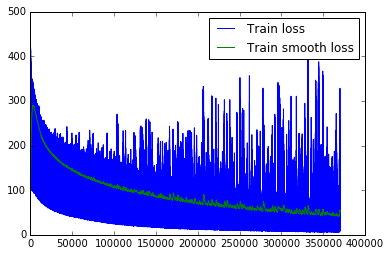

In [4]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 10000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 10 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = RNN(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()

plt.show()